# Homework 1 - EECS 600 Deep Learning

Name: Sheng Guan

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 9/24/19 - midnight EST

100 Points Total

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 1.14.0
Eager execution: True


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255. 

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

# Question 1
Implement a neural network with one hidden layer with 32 neurons with sigmoid activation functions and a softmax output layer with 10 outputs to classify the loaded MNIST digits as the number they represent. Each training step should be done with a batch size of 64 and the the order of the training samples should be shuffled each epoch. You may use the [tensorflow data API](https://www.tensorflow.org/beta/tutorials/load_data/numpy) to assist with that.

The loss function should me [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) between the prediction and the true results. At the end of each training epoch, the accuracy and loss value should be calculated for the whole training dataset and testing dataset. Use stochastic gradient descent as the training algorithm. Determine an effective learning rate.

In [0]:
#create dataset by tensorflow data API
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#print(train_dataset)


In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100



train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#print(train_dataset)
#print(test_dataset)
#train_batch = tf.convert_to_tensor(train_dataset)
#test_batch = tf.convert_to_tensor(test_dataset)
test_batch_size= x_test.shape[0]
#print(test_batch_size)
test_dataset = test_dataset.batch(test_batch_size)
#print(type(train_dataset))

In [0]:
features, labels = next(iter(train_dataset))
#print(features.shape)
#print (labels[0])

In [0]:
#set the random seed, such that the results can be reproduced
tf.compat.v1.random.set_random_seed(4321)

In [0]:
class Model(object):
    def __init__(self, num_hidden=32 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model = Model()



In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)




In [9]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model, inputs, outputs, learning_rate)
    
  #current_loss = tf.reduce_mean([loss(model(x), tf.one_hot(y, 10, dtype='float32')) for x, y in iter(train_dataset)])
  current_loss = loss(model(inputs), outputs).numpy()
  current_accu (tf.argmax(model(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.11, accuracy is 0.22 
The testing loss value and accuracy for epoch 0 is 0.11, accuracy is 0.21 
The training loss value and accuracy for epoch 1 is 0.09, accuracy is 0.34 
The testing loss value and accuracy for epoch 1 is 0.08, accuracy is 0.37 
The training loss value and accuracy for epoch 2 is 0.07, accuracy is 0.47 
The testing loss value and accuracy for epoch 2 is 0.07, accuracy is 0.47 
The training loss value and accuracy for epoch 3 is 0.06, accuracy is 0.50 
The testing loss value and accuracy for epoch 3 is 0.06, accuracy is 0.54 
The training loss value and accuracy for epoch 4 is 0.05, accuracy is 0.59 
The testing loss value and accuracy for epoch 4 is 0.06, accuracy is 0.59 
The training loss value and accuracy for epoch 5 is 0.05, accuracy is 0.66 
The testing loss value and accuracy for epoch 5 is 0.05, accuracy is 0.63 
The training loss value and accuracy for epoch 6 is 0.04, accuracy is 0.72 
The testing loss v

In [0]:
#just quick test MSE
#import numpy as np
#a=tf.constant([1.0,0.0])
#b=tf.constant([0.0,1.0])
#print(a.shape)
#print(b.shape)
#c= tf.reduce_mean(tf.square(b - a))
#print(c.numpy())


Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

.

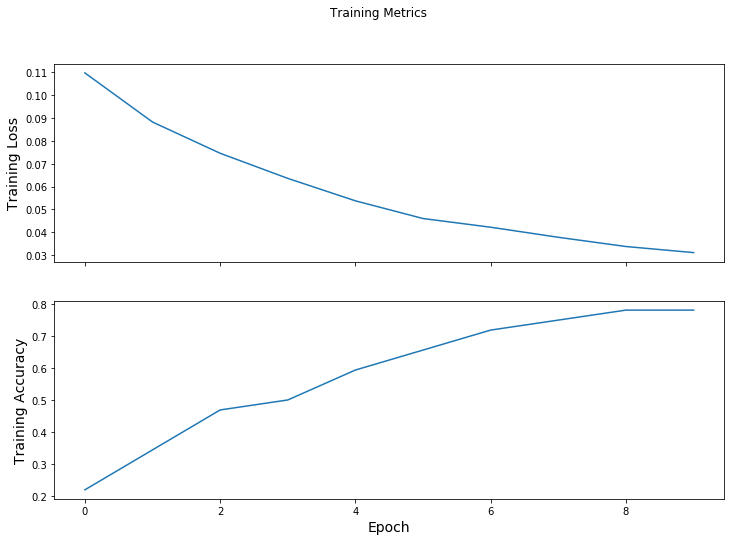

In [10]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

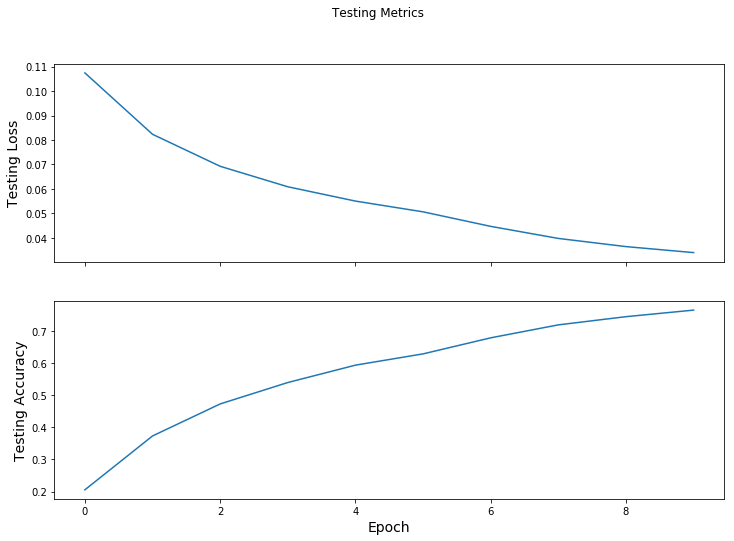

In [11]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Question 1 Part 2
Change the size of your hidden layer to 16 neurons and re-run the training.

In [0]:
class Model2(object):
    def __init__(self, num_hidden=16 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model2 = Model2()



In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)




In [14]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model2, inputs, outputs, learning_rate)
    
  
  current_loss = loss(model2(inputs), outputs).numpy()
  current_accu (tf.argmax(model2(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model2(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model2(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.10, accuracy is 0.09 
The testing loss value and accuracy for epoch 0 is 0.10, accuracy is 0.16 
The training loss value and accuracy for epoch 1 is 0.09, accuracy is 0.12 
The testing loss value and accuracy for epoch 1 is 0.09, accuracy is 0.27 
The training loss value and accuracy for epoch 2 is 0.09, accuracy is 0.25 
The testing loss value and accuracy for epoch 2 is 0.08, accuracy is 0.36 
The training loss value and accuracy for epoch 3 is 0.08, accuracy is 0.41 
The testing loss value and accuracy for epoch 3 is 0.07, accuracy is 0.43 
The training loss value and accuracy for epoch 4 is 0.07, accuracy is 0.53 
The testing loss value and accuracy for epoch 4 is 0.06, accuracy is 0.54 
The training loss value and accuracy for epoch 5 is 0.07, accuracy is 0.56 
The testing loss value and accuracy for epoch 5 is 0.06, accuracy is 0.58 
The training loss value and accuracy for epoch 6 is 0.06, accuracy is 0.56 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)



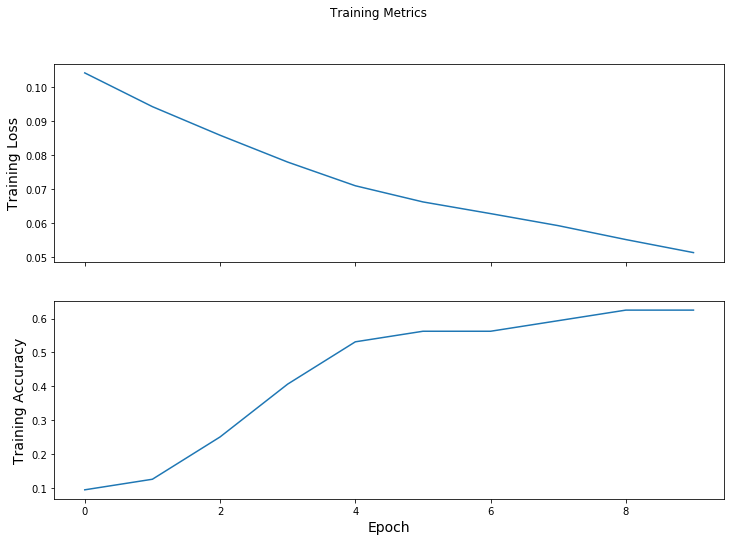

In [15]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

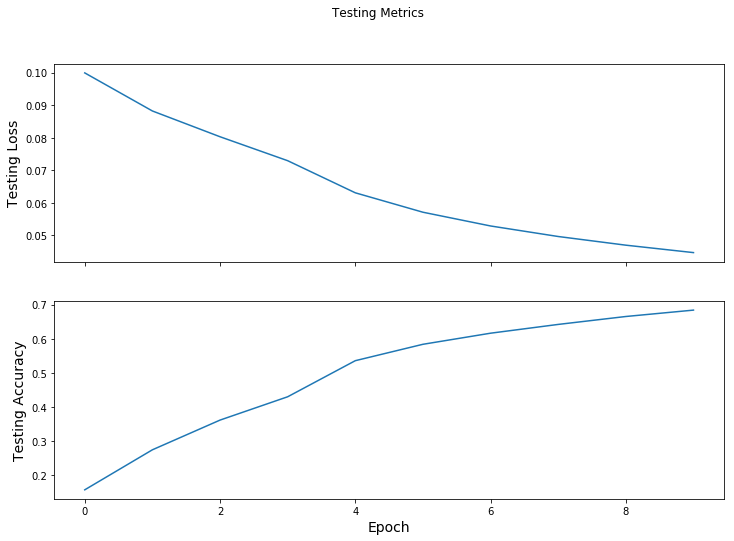

In [16]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

##Question 1 Part 3
Change your network architecture to have two hidden layers each of size 16 and re-run the training

In [0]:
class Model3(object):
    def __init__(self, num_hidden1=16 , num_hidden2=16,  num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden1),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden1),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_hidden2),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden1, num_hidden2),
            mean=0.0,
            stddev=1.0,  
            #seed=None,
            name='W2'))
        self.b3 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b3'))
        self.W3 = tf.Variable(tf.random.normal(
            (num_hidden2, num_output),
            mean=0.0,
            stddev=1.0,  
            #seed=None,
            name='W3'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.sigmoid(
         tf.linalg.matmul(a1,self.W2)+self.b2
         )
     a3 = tf.nn.softmax(
         tf.linalg.matmul(a2, self.W3)+ self.b3
     )
     return a3

model3 = Model3()

In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, dW3, db1, db2,db3 = t.gradient(current_loss, [model.W1, model.W2, model.W3, model.b1, model.b2, model.b3])
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.W3.assign_sub(learning_rate * dW3)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)
  model.b3.assign_sub(learning_rate * db3)


In [19]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model3, inputs, outputs, learning_rate)
    
  
  current_loss = loss(model3(inputs), outputs).numpy()
  current_accu (tf.argmax(model3(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model3(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model3(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.09, accuracy is 0.12 
The testing loss value and accuracy for epoch 0 is 0.09, accuracy is 0.24 
The training loss value and accuracy for epoch 1 is 0.09, accuracy is 0.22 
The testing loss value and accuracy for epoch 1 is 0.08, accuracy is 0.30 
The training loss value and accuracy for epoch 2 is 0.08, accuracy is 0.28 
The testing loss value and accuracy for epoch 2 is 0.08, accuracy is 0.35 
The training loss value and accuracy for epoch 3 is 0.08, accuracy is 0.31 
The testing loss value and accuracy for epoch 3 is 0.08, accuracy is 0.39 
The training loss value and accuracy for epoch 4 is 0.08, accuracy is 0.38 
The testing loss value and accuracy for epoch 4 is 0.07, accuracy is 0.43 
The training loss value and accuracy for epoch 5 is 0.08, accuracy is 0.41 
The testing loss value and accuracy for epoch 5 is 0.07, accuracy is 0.49 
The training loss value and accuracy for epoch 6 is 0.07, accuracy is 0.41 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)
![alt text](https://)

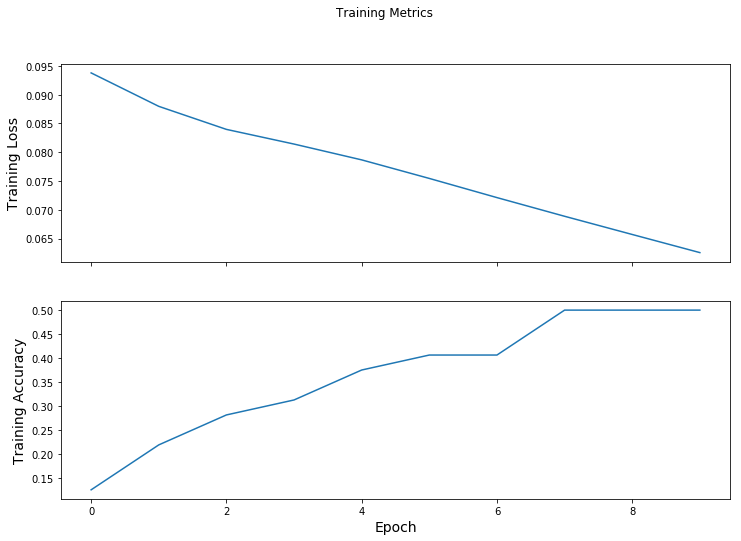

In [20]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

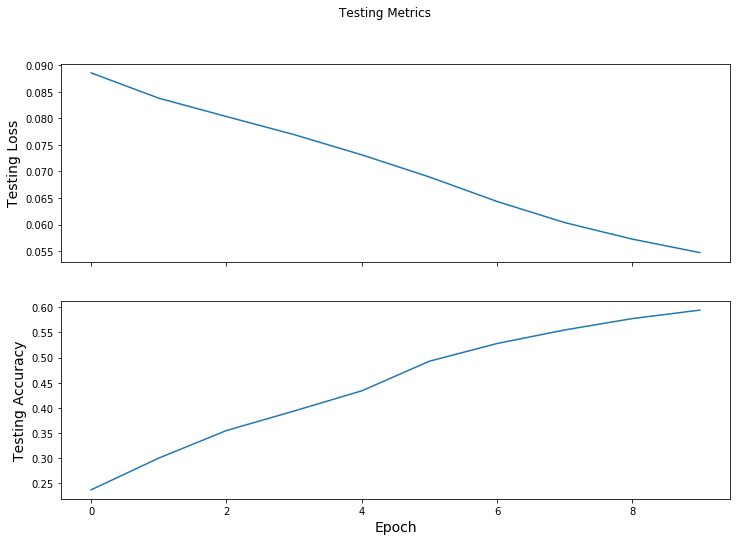

In [21]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Question 1 Part 4
Change the activation functions in the hidden layer to ReLU and re-run the training

In [0]:
#This part I interpret it as still to make a comparison with model 1
class Model4(object):
    def __init__(self, num_hidden=32 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.nn.relu(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model4 = Model4()


In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
    
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)

In [24]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model4, inputs, outputs, learning_rate)
    
  
  current_loss = loss(model4(inputs), outputs).numpy()
  current_accu (tf.argmax(model4(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model4(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model4(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.14, accuracy is 0.22 
The testing loss value and accuracy for epoch 0 is 0.13, accuracy is 0.30 
The training loss value and accuracy for epoch 1 is 0.13, accuracy is 0.34 
The testing loss value and accuracy for epoch 1 is 0.12, accuracy is 0.39 
The training loss value and accuracy for epoch 2 is 0.12, accuracy is 0.34 
The testing loss value and accuracy for epoch 2 is 0.10, accuracy is 0.46 
The training loss value and accuracy for epoch 3 is 0.10, accuracy is 0.47 
The testing loss value and accuracy for epoch 3 is 0.08, accuracy is 0.57 
The training loss value and accuracy for epoch 4 is 0.09, accuracy is 0.50 
The testing loss value and accuracy for epoch 4 is 0.08, accuracy is 0.59 
The training loss value and accuracy for epoch 5 is 0.09, accuracy is 0.50 
The testing loss value and accuracy for epoch 5 is 0.08, accuracy is 0.60 
The training loss value and accuracy for epoch 6 is 0.09, accuracy is 0.53 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


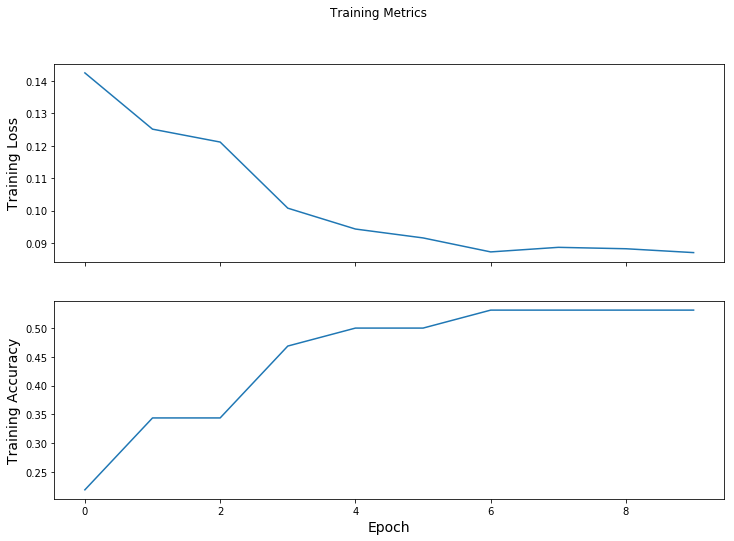

In [25]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

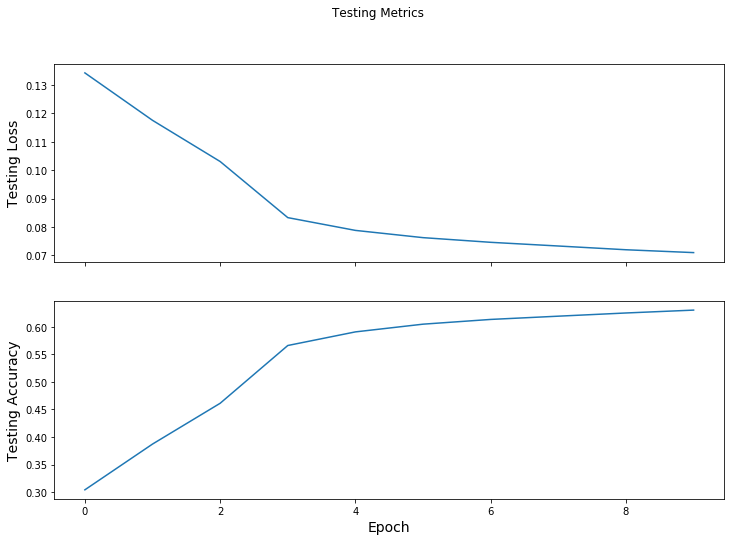

In [26]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Question 1 part 5
Describe how changing the size of the hidden layer and the number of hidden layers impacted the predictions of the network.

Generally speaking, adding the size of the hidden layer will increase the model performance since the model have more parameters to configure and the capacity of the model increases. However, by experiment results, we find this is not always the case (keep the same learning rate and the epochs number, not shown in this ipynb results). The conclusion is not always the model with higher compacity is the better since we have the simplicity rule that requires us to have a ideal small model. It also may depend on your dataset and how you shuffle your data.

Similarly, generally speaking, when you increase the number of hidden layers, the model compacity will increase and you will get better performance. However, in the experiment results we provided in this ipynb file, you can see the model performance decreases since for simplicity we didn't fine-tune our model and offline experiment results do show the performance will get improved. The conclusion is similar as the above.

# Question 2 Part 1

Re-use the network built above but modify the update step to the following.

\begin{align}
V_t = \beta V_{t-1} + (1-\beta)g_t \\
W_{t+1} = W_t - \alpha V_t
\end{align}

where $V_t$ is the update vector for step $t$. Use $\beta=0.1$.

In [0]:
#accoding the above equations, my understanding is this is similar to momentum but not exactly the momentum we learned from the class
import numpy as np
class Model_Momentum(object):
    def __init__(self, num_hidden=32 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))
        #self.previous_gradient_w1=np.zeros((num_inputs,num_hidden))
        #self.previous_gradient_w2=np.zeros((num_hidden,num_output))
        #self.previous_gradient_b1=np.zeros(num_hidden)
        #self.previous_gradient_b2=np.zeros(num_output)
        self.previous_gradient_w1=0.0
        self.previous_gradient_w2=0.0
        self.previous_gradient_b1=0.0
        self.previous_gradient_b2=0.0
        self.balancing_factor =0.1
        

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model_momentum = Model_Momentum()


In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])

    
    dW1 = (1-model.balancing_factor)*dW1+ model.balancing_factor*model.previous_gradient_w1
    dW2 = (1-model.balancing_factor)*dW2+ model.balancing_factor*model.previous_gradient_w2
    db1 = (1-model.balancing_factor)*db1+ model.balancing_factor*model.previous_gradient_b1
    db2 = (1-model.balancing_factor)*db2+ model.balancing_factor*model.previous_gradient_b2
    
    model.previous_gradient_w1 = dW1
    model.previous_gradient_w2 = dW2
    model.previous_gradient_b1 = db1
    model.previous_gradient_b2 = db2
    
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)

In [29]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model_momentum, inputs, outputs, learning_rate)
    
  
  current_loss = loss(model_momentum(inputs), outputs).numpy()
  current_accu (tf.argmax(model_momentum(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model_momentum(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model_momentum(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.09, accuracy is 0.25 
The testing loss value and accuracy for epoch 0 is 0.10, accuracy is 0.25 
The training loss value and accuracy for epoch 1 is 0.08, accuracy is 0.34 
The testing loss value and accuracy for epoch 1 is 0.08, accuracy is 0.37 
The training loss value and accuracy for epoch 2 is 0.08, accuracy is 0.47 
The testing loss value and accuracy for epoch 2 is 0.07, accuracy is 0.48 
The training loss value and accuracy for epoch 3 is 0.07, accuracy is 0.50 
The testing loss value and accuracy for epoch 3 is 0.06, accuracy is 0.54 
The training loss value and accuracy for epoch 4 is 0.06, accuracy is 0.50 
The testing loss value and accuracy for epoch 4 is 0.06, accuracy is 0.59 
The training loss value and accuracy for epoch 5 is 0.06, accuracy is 0.56 
The testing loss value and accuracy for epoch 5 is 0.05, accuracy is 0.63 
The training loss value and accuracy for epoch 6 is 0.05, accuracy is 0.59 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


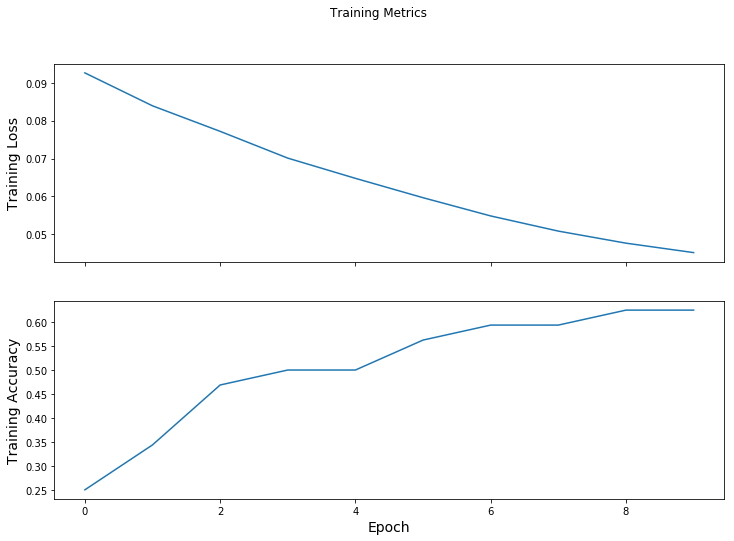

In [30]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

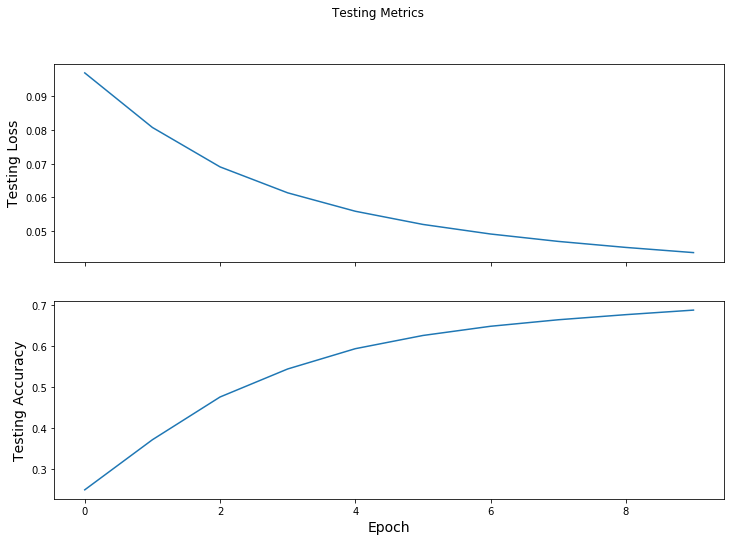

In [31]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Question 2 part 2
Re-run the training with $\beta=0.9$

In [0]:
#accoding the above equations, my understanding is this is similar to momentum but not exactly the momentum we learned from the class
class Model_Momentum2(object):
    def __init__(self, num_hidden=32 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))
        #The python will automatically change the matrix dimension
        self.previous_gradient_w1=0.0
        self.previous_gradient_w2=0.0
        self.previous_gradient_b1=0.0
        self.previous_gradient_b2=0.0
        self.balancing_factor =0.9
        

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model_momentum2 = Model_Momentum2()

In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])

    
    dW1 = (1-model.balancing_factor)*dW1+ model.balancing_factor*model.previous_gradient_w1
    #print(dW1)
    dW2 = (1-model.balancing_factor)*dW2+ model.balancing_factor*model.previous_gradient_w2
    db1 = (1-model.balancing_factor)*db1+ model.balancing_factor*model.previous_gradient_b1
    db2 = (1-model.balancing_factor)*db2+ model.balancing_factor*model.previous_gradient_b2
    
    model.previous_gradient_w1 = dW1
    #print(model.previous_gradient_w1)
    model.previous_gradient_w2 = dW2
    model.previous_gradient_b1 = db1
    model.previous_gradient_b2 = db2
    
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)

In [34]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model_momentum2, inputs, outputs, learning_rate)
    
  
  current_loss = loss(model_momentum2(inputs), outputs).numpy()
  current_accu (tf.argmax(model_momentum2(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model_momentum2(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model_momentum2(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')

The training loss value and accuracy for epoch 0 is 0.11, accuracy is 0.12 
The testing loss value and accuracy for epoch 0 is 0.10, accuracy is 0.27 
The training loss value and accuracy for epoch 1 is 0.10, accuracy is 0.25 
The testing loss value and accuracy for epoch 1 is 0.08, accuracy is 0.38 
The training loss value and accuracy for epoch 2 is 0.09, accuracy is 0.34 
The testing loss value and accuracy for epoch 2 is 0.07, accuracy is 0.48 
The training loss value and accuracy for epoch 3 is 0.08, accuracy is 0.41 
The testing loss value and accuracy for epoch 3 is 0.06, accuracy is 0.55 
The training loss value and accuracy for epoch 4 is 0.07, accuracy is 0.44 
The testing loss value and accuracy for epoch 4 is 0.05, accuracy is 0.61 
The training loss value and accuracy for epoch 5 is 0.06, accuracy is 0.44 
The testing loss value and accuracy for epoch 5 is 0.05, accuracy is 0.66 
The training loss value and accuracy for epoch 6 is 0.05, accuracy is 0.59 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


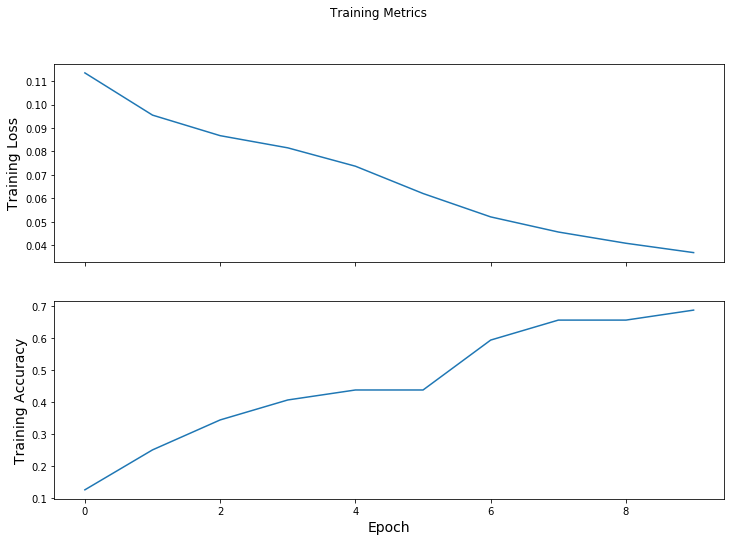

In [35]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

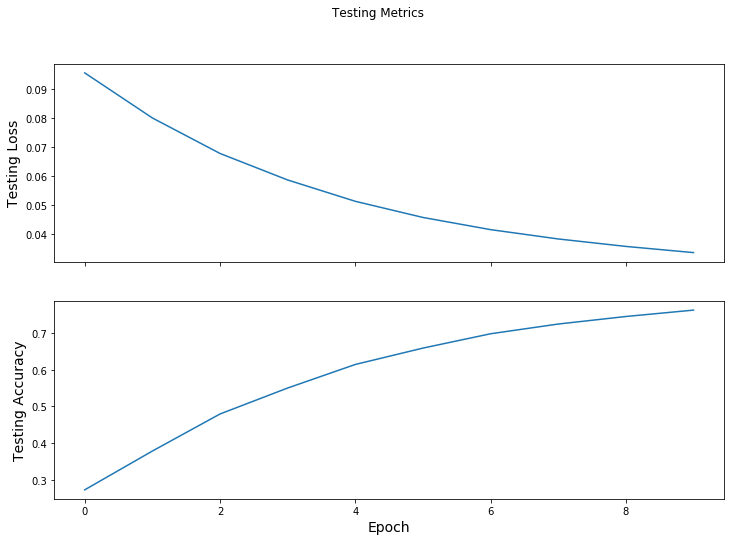

In [36]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Question 2 Part 3
Describe the differences in training results comparing the different values of $\beta$.

The value of \beta in this implementtion is a balancing factor between the previous update vector and the current gradient calculated in the current step. If the value of \beta is small, it means the model updating is more close to the graident descent updation. If the value of \beta is large, it means the model relies on more heavily of the previously calculated updation vector. Out experiment results also support this claim. In our experimental case, the model achieves better performance when it considers more about previous direction. That supports the idea that we should consider the previous steps to enhance the performance.

## Question 2 Part 4
Re-use the network above, but implement the [AdaDelta](http://ruder.io/optimizing-gradient-descent/index.html#adadelta) learning algorithm. You can assume an initial value of $RMS[\nabla \theta]_{t-1} = 1.0$

In [0]:
#accoding the above equations, my understanding is this is similar to momentum but not exactly the momentum we learned from the class
class Model_Adadelta(object):
    def __init__(self, num_hidden=32 , num_output=10, num_inputs=784):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            #seed=None,
            name='W2'))
        self.state_w1=np.zeros((num_inputs,num_hidden))
        self.state_w2=np.zeros((num_hidden,num_output))
        self.state_b1=np.zeros(num_hidden)
        self.state_b2=np.zeros(num_output)
        self.delta_w1 =0.0
        self.delta_w2 =0.0
        self.delta_b1 =0.0
        self.delta_b2 =0.0
        self.epsilon = 1e-5
        self.rho =0.1
        self.rms_delta_x =1.0
        

    def __call__(self, x):
        return self.forward(x)

    def forward(self,x):

     a1 = tf.sigmoid(
         tf.linalg.matmul(x,self.W1)+self.b1
         )
     a2 = tf.nn.softmax(
         tf.linalg.matmul(a1, self.W2)+ self.b2
     )
     return a2

model_adadelta = Model_Adadelta()

In [0]:
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))

def update_G(state_variable,gradient,rho):
  state_variable =rho*state_variable+(1-rho)*tf.square(gradient)
  return state_variable


def train_step(model, inputs, outputs):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
    model.state_w1 = update_G(model.state_w1,dW1,model.rho)
    model.state_w2 = update_G(model.state_w2,dW2,model.rho)
    model.state_b1 = update_G(model.state_b1,db1,model.rho)
    model.state_b2 = update_G(model.state_b2,db2,model.rho)
    
    #calculate RMS dW1, dW2, db1, db2
    RMS_dW1 = tf.sqrt(model.state_w1 +model.epsilon)
    RMS_dW2 = tf.sqrt(model.state_w2 +model.epsilon)
    RMS_db1 = tf.sqrt(model.state_b1 +model.epsilon)
    RMS_db2 = tf.sqrt(model.state_b2 +model.epsilon)
    
    #Compute the updation vector
    updation_w1 = tf.sqrt(model.delta_w1+model.epsilon)/RMS_dW1 * dW1
    updation_w2 = tf.sqrt(model.delta_w2+model.epsilon)/RMS_dW2 * dW2
    updation_b1 = tf.sqrt(model.delta_b1+model.epsilon)/RMS_db1 * db1
    updation_b2 = tf.sqrt(model.delta_b2+model.epsilon)/RMS_db2 * db2
    
    #Update the delta variables
    model.delta_w1 = model.rho*model.delta_w1 +(1-model.rho)*updation_w1*updation_w1
    model.delta_w2 = model.rho*model.delta_w2 +(1-model.rho)*updation_w2*updation_w2
    model.delta_b1 = model.rho*model.delta_b1 +(1-model.rho)*updation_b1*updation_b1
    model.delta_b2 = model.rho*model.delta_b2 +(1-model.rho)*updation_b2*updation_b2
    
  
  model.W1.assign_sub(updation_w1)
  model.W2.assign_sub(updation_w2)
  model.b1.assign_sub(updation_b1)
  model.b2.assign_sub(updation_b2)

In [0]:
#just quick test sqrt
#import numpy as np
#a=tf.constant([1.0,0.0])
#b=tf.constant([1.0,1.0])
#print(a.shape)
#print(b.shape)
#c=tf.sqrt(a+b)
#print(c.numpy())

In [40]:
learning_rate = 0.5

#keep results for plotting
train_loss_results =[]
train_accuracy_results =[]
test_loss_results = []
test_accuracy_results =[]

num_epochs =10

for epoch in range(num_epochs):
  current_accu = tfe.metrics.Accuracy()
  current_test_accu = tfe.metrics.Accuracy()
  for inputs, outputs in iter(train_dataset):
    outputs = tf.one_hot(outputs, 10, dtype='float32')
    train_step(model_adadelta, inputs, outputs)
    
  
  current_loss = loss(model_adadelta(inputs), outputs).numpy()
  current_accu (tf.argmax(model_adadelta(inputs),axis=1,output_type=tf.int32),tf.argmax(outputs,axis=1,output_type=tf.int32))
  #append the train_loss and train_accu into list
  train_loss_results.append(current_loss)
  train_accuracy_results.append(current_accu.result())
  
  for test_inputs, test_outputs in iter(test_dataset):
    test_outputs = tf.one_hot(test_outputs, 10, dtype='float32')
    #print(test_outputs.shape)
  current_test_loss = loss(model_adadelta(test_inputs), test_outputs).numpy()
  current_test_accu(tf.argmax(model_adadelta(test_inputs),axis=1,output_type=tf.int32),tf.argmax(test_outputs,axis=1,output_type=tf.int32))
  #append the test_loss and test_accu into list
  test_loss_results.append(current_test_loss)
  test_accuracy_results.append(current_test_accu.result())
   
  #print(current_accu.result())
  print(f'The training loss value and accuracy for epoch {epoch} is {current_loss:0.2f}, accuracy is {current_accu.result():0.2f} ')
  print(f'The testing loss value and accuracy for epoch {epoch} is {current_test_loss:0.2f}, accuracy is {current_test_accu.result():0.2f} ')


The training loss value and accuracy for epoch 0 is 0.09, accuracy is 0.38 
The testing loss value and accuracy for epoch 0 is 0.08, accuracy is 0.39 
The training loss value and accuracy for epoch 1 is 0.07, accuracy is 0.47 
The testing loss value and accuracy for epoch 1 is 0.07, accuracy is 0.51 
The training loss value and accuracy for epoch 2 is 0.06, accuracy is 0.53 
The testing loss value and accuracy for epoch 2 is 0.06, accuracy is 0.58 
The training loss value and accuracy for epoch 3 is 0.06, accuracy is 0.59 
The testing loss value and accuracy for epoch 3 is 0.05, accuracy is 0.62 
The training loss value and accuracy for epoch 4 is 0.05, accuracy is 0.66 
The testing loss value and accuracy for epoch 4 is 0.05, accuracy is 0.65 
The training loss value and accuracy for epoch 5 is 0.05, accuracy is 0.62 
The testing loss value and accuracy for epoch 5 is 0.04, accuracy is 0.67 
The training loss value and accuracy for epoch 6 is 0.04, accuracy is 0.66 
The testing loss v

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


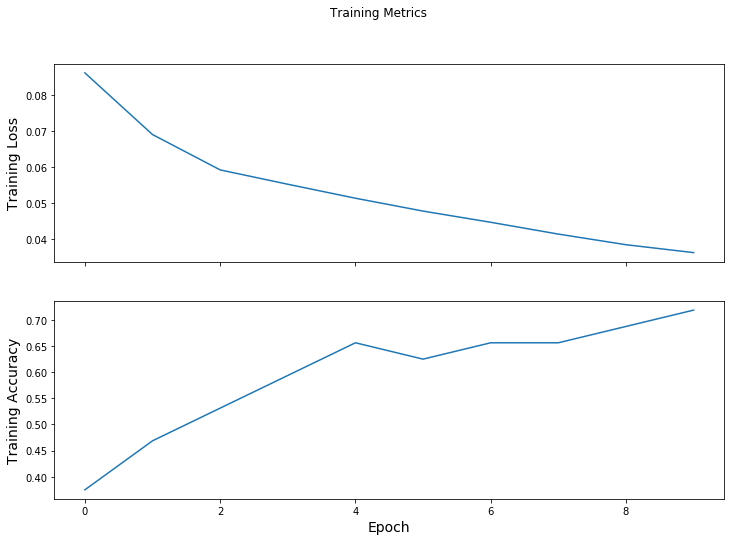

In [41]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Training Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Training Loss",fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Training Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

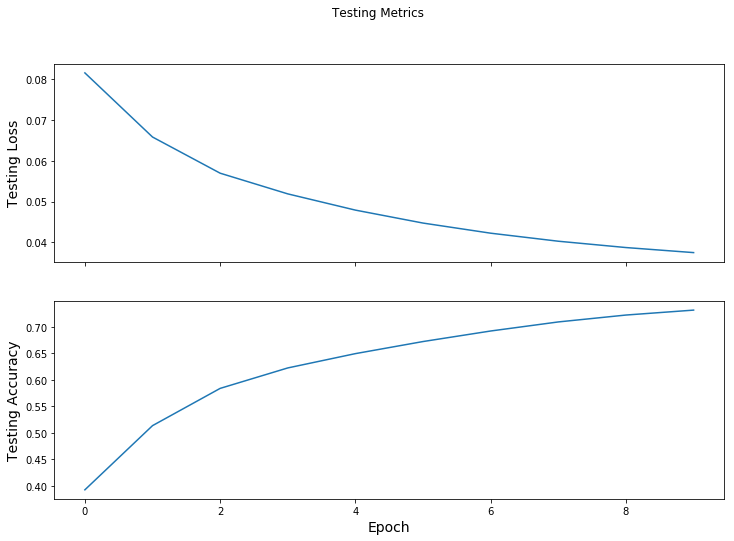

In [42]:
#The below piece of code refers tensorflow tutorials-- custom training walkthrough
#Testing Metrics
fig, axes = plt.subplots(2,sharex=True, figsize =(12,8))
fig.suptitle('Testing Metrics')
axes[0].set_ylabel("Testing Loss",fontsize=14)
axes[0].plot(test_loss_results)
axes[1].set_ylabel("Testing Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()